In [1]:
%reload_ext autotime
import requests
import requests_cache
requests_cache.install_cache('cache')
import requests_html
import math
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
from pprint import pprint
import re
import traceback
pd.set_option("display.max_columns", None)
#pd.set_option("display.max_colwidth", None)
existing_df = pd.read_excel("givealittle_health.xlsx")
existing_df = existing_df[existing_df.timeLeft == "closed"]
existing_df

,title,pitch,hero,uri,amountRaised,goal,timeLeft,action,actionUri,start,end,n_questions,location,n_donors,description,use_of_funds,whos_involved,moderated,n_updates,updates,Q&A
24,Help me support my sick father,Raising money to see my sick father,https://static.givealittle.co.nz/assets/hero/c...,https://givealittle.co.nz/cause/help-me-suppor...,1555.00,2000.0,closed,Read more,https://givealittle.co.nz/cause/help-me-suppor...,20 Oct 2024,27 Oct 2024,0,"Greenhithe, Auckland",39.0,Hey guys. I'm raising money in order to travel...,Travel funds to get from Auckland to Nelson an...,"Created by, and paying to a verified bank acco...",Page Moderated,NaN,NaN,NaN
34,My Cambodian Sister Fighting the Big C,Please help my Cambodian sister fight the big C.,https://static.givealittle.co.nz/assets/hero/e...,https://givealittle.co.nz/cause/my-cambodian-s...,2000.00,3000.0,closed,Read more,https://givealittle.co.nz/cause/my-cambodian-s...,16 Oct 2024,29 Oct 2024,0,Nationwide,26.0,"Last year, Channa was my tour guide in Cambodi...","rent, groceries, transport, and other daily ne...","Created by, and paying to a verified bank acco...",Page Moderated,1.0,Thank you!!!\n1 November 2024\nThank you for o...,NaN
42,Hunter's Top Surgery,Hunter's Top Surgery,https://static.givealittle.co.nz/assets/hero/4...,https://givealittle.co.nz/cause/h-top-surgery-1,1685.00,0.0,closed,Read more,https://givealittle.co.nz/cause/h-top-surgery-1,14 Oct 2024,28 Oct 2024,0,Nationwide,20.0,Hi All!\nI hope everyone is slaying! I know th...,Helping me fund my top surgery!!All funds dona...,"Created by Ayesha Hunwick, paying to a verifie...",Page Moderated,NaN,NaN,NaN
48,Flights needed NZ-London to help 83 year old m...,Raising funds to send a caring daughter to Lon...,https://static.givealittle.co.nz/assets/hero/0...,https://givealittle.co.nz/cause/flights-needed...,0.00,3340.0,closed,Read more,https://givealittle.co.nz/cause/flights-needed...,13 Oct 2024,16 Oct 2024,0,NaN,NaN,My mother has breast cancer and at 83 is havin...,Just the flights,"Created by, and paying to a verified bank acco...",Page Moderated,NaN,NaN,NaN
49,Help our Beautiful Dad get the Care he Deserves,Help Dad get the treatment he needs,https://static.givealittle.co.nz/assets/hero/b...,https://givealittle.co.nz/cause/help-our-beaut...,11232.19,0.0,closed,Read more,https://givealittle.co.nz/cause/help-our-beaut...,13 Oct 2024,25 Oct 2024,0,NaN,99.0,We are heartbroken to share that our beloved D...,The costs of going into the Aotearoa Private H...,Created by_x000D_\nFrankie Woods \n\n\n\n_x00...,Page Moderated,1.0,"THANK YOU!\n23 October 2024\nKia ora koutou,\n...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10413,Amber and Daniel were twins born on 24th and 2...,Raising money for the little McSweeney family ...,https://static.givealittle.co.nz/assets/hero/a...,https://givealittle.co.nz/cause/hartleytwinsmi...,4834.00,0.0,closed,Read more,https://givealittle.co.nz/cause/hartleytwinsmi...,2 May 2016,6 Jun 2016,0,Canterbury,122.0,PLEASE READ THE UPDATE TO THIS POST UNDER UPDA...,NaN,"Created by, and paying to a verified bank acco...",Page Moderated,1.0,Attention all followers of our story\n31 May 2...,NaN
10414,"Tania Whanau, known by most as Tarnz, is a str...",Since February '16 Tarnz has undergone two ope...,https://static.givealittle.co.nz/assets/hero/6...,https://givealittle.co.nz/cause/fightbreastcan...,1550.00,0.0,closed,Read more,https://givealittle.co.nz/cause/fightbreastcan...,1 May 2016,22 Jul 2016,0,Hawke's Bay,34.0,"Tania Whanau, known by most as Tarnz, is a str...",NaN,Created by_x000D_\n _x000D_\n Nanc...,Page Moderated,NaN,NaN,NaN
10415,Cardiology Fundraiser,Fundraising for patients & families affected b...,https://static.givealittle.co.nz/assets/hero/b...,https://givealittle.co.nz/cause/fund4aheart,915.00,0.0,closed,Read more,https://givealittle.co.nz/cause/fund4aheart,1 May 2016,15 Aug 2016,0,Waikato,9.0,We aim to provide clients with the most u

In [2]:
# takes about 7m without cache.sqlite
URL = "https://givealittle.co.nz/search/api?category=health&showClosed=True&page=cause&sort=newest"
first = requests.get(URL).json()
total = first["total"]
results = first["results"]
last_page = math.ceil(total / len(results))
print(f"Last page: {last_page}")
last_page = min(last_page, 1000)
for page in tqdm(range(2, last_page + 1)):
    page_results = requests.get(f"{URL}&p={page}").json()
    results.extend(page_results["results"])

Last page: 1239


  0%|          | 0/999 [00:00<?, ?it/s]

In [3]:
df = pd.DataFrame(results)
df.uri = "https://givealittle.co.nz" + df.uri
df.actionUri = "https://givealittle.co.nz" + df.actionUri
df

,title,pitch,hero,uri,amountRaised,goal,timeLeft,action,actionUri
0,Young mother of 3 recently diagnosed with aggr...,Young mother of three fighting aggresive breas...,https://static.givealittle.co.nz/assets/hero/e...,https://givealittle.co.nz/cause/young-mother-o...,3900.00,0.0,181 days to go,Donate,https://givealittle.co.nz/donate/cause/young-m...
1,Finlee Bremners Road to recovery,Helping our great friends navigate Finlee's lo...,https://static.givealittle.co.nz/assets/hero/2...,https://givealittle.co.nz/cause/finlee-bremner...,4500.00,0.0,177 days to go,Donate,https://givealittle.co.nz/donate/cause/finlee-...
2,Paula Matafahi's Grade 4 Brain Cancer Fight - ...,This page has been set up to help Paula access...,https://static.givealittle.co.nz/assets/hero/b...,https://givealittle.co.nz/cause/paulas-stage-4...,47522.15,55000.0,27 days to go,Donate,https://givealittle.co.nz/donate/cause/paulas-...
3,Our Sweet boy Jairo,Please help Jairo get the testing and screenin...,https://static.givealittle.co.nz/assets/hero/2...,https://givealittle.co.nz/cause/our-sweet-boy-...,925.00,1000.0,19 days to go,Donate,https://givealittle.co.nz/donate/cause/our-swe...
4,Em’s MS Journey,Stemcell replacement for Em’s MS Journey. Clín...,https://static.givealittle.co.nz/assets/hero/6...,https://givealittle.co.nz/cause/ems-ms-journey,9640.00,90000.0,178 days to go,Donate,https://givealittle.co.nz/donate/cause/ems-ms-...
...,...,...,...,...,...,...,...,...,...
9994,Joe and Dorothy Harris,"Joseph Harris, a generous hard working friend ...",https://static.givealittle.co.nz/assets/hero/2...,https://givealittle.co.nz/cause/joeharris,510.00,0.0,closed,Read more,https://givealittle.co.nz/cause/joeharris
9995,Kelvin Bartz and Sandra Parker,Kelvin Bartz has been diagnosed with a fatal i...,https://static.givealittle.co.nz/assets/hero/d...,https://givealittle.co.nz/cause/kelvinbartz,345.00,0.0,closed,Read more,https://givealittle.co.nz/cause/kelvinbartz
9996,Mesh Removal Surgery for Christine Williams,My name is Christine Williams. I need a specia...,https://static.givealittle.co.nz/assets/hero/9...,https://givealittle.co.nz/cause/christinewilli...,18855.00,70000.0,closed,Read more,https://givealittle.co.nz/cause/christinewilli...
9997,Help Kyle fight Ewing Sarcoma Cancer,Help support Kyle over the next 12 months thro...,https://static.givealittle.co.nz/assets/hero/1...,https://givealittle.co.nz/cause/kylecarter,2860.00,0.0,closed,Read more,https://givealittle.co.nz/cause/kylecarter


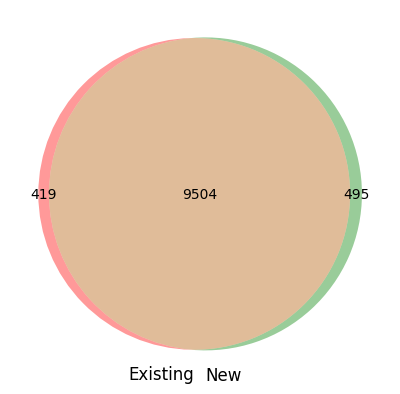

In [4]:
from matplotlib_venn import venn2
venn2([set(existing_df.uri), set(df.uri)], set_labels=["Existing", "New"])

In [5]:
df = df[~df.uri.isin(existing_df.uri)]
df

,title,pitch,hero,uri,amountRaised,goal,timeLeft,action,actionUri
0,Young mother of 3 recently diagnosed with aggr...,Young mother of three fighting aggresive breas...,https://static.givealittle.co.nz/assets/hero/e...,https://givealittle.co.nz/cause/young-mother-o...,3900.00,0.0,181 days to go,Donate,https://givealittle.co.nz/donate/cause/young-m...
1,Finlee Bremners Road to recovery,Helping our great friends navigate Finlee's lo...,https://static.givealittle.co.nz/assets/hero/2...,https://givealittle.co.nz/cause/finlee-bremner...,4500.00,0.0,177 days to go,Donate,https://givealittle.co.nz/donate/cause/finlee-...
2,Paula Matafahi's Grade 4 Brain Cancer Fight - ...,This page has been set up to help Paula access...,https://static.givealittle.co.nz/assets/hero/b...,https://givealittle.co.nz/cause/paulas-stage-4...,47522.15,55000.0,27 days to go,Donate,https://givealittle.co.nz/donate/cause/paulas-...
3,Our Sweet boy Jairo,Please help Jairo get the testing and screenin...,https://static.givealittle.co.nz/assets/hero/2...,https://givealittle.co.nz/cause/our-sweet-boy-...,925.00,1000.0,19 days to go,Donate,https://givealittle.co.nz/donate/cause/our-swe...
4,Em’s MS Journey,Stemcell replacement for Em’s MS Journey. Clín...,https://static.givealittle.co.nz/assets/hero/6...,https://givealittle.co.nz/cause/ems-ms-journey,9640.00,90000.0,178 days to go,Donate,https://givealittle.co.nz/donate/cause/ems-ms-...
...,...,...,...,...,...,...,...,...,...
2445,"Help 20,000 New Zealanders suffering from Infl...",Helen hopes to help others shortcut the 16 yea...,https://static.givealittle.co.nz/assets/hero/f...,https://givealittle.co.nz/cause/help-20000-nze...,3525.00,25000.0,39 days to go,Donate,https://givealittle.co.nz/donate/cause/help-20...
2553,HELP NEL GET GENDER AFFIRMING TOP SURGERY,I am raising money for gender affirming top su...,https://static.givealittle.co.nz/assets/hero/6...,https://givealittle.co.nz/cause/nel-surgery-fund,3514.29,16000.0,11 days to go,Donate,https://givealittle.co.nz/donate/cause/nel-sur...
2584,GET LORA GENDER AFFIRMING SURGERY,I am raising funds for urgent gender affirming...,https://static.givealittle.co.nz/assets/hero/5...,https://givealittle.co.nz/cause/lora-surgery-fund,10987.17,23000.0,3 days to go,Donate,https://givealittle.co.nz/donate/cause/lora-su...
2702,Eye Care For Africa - Te Araroa,Eye Care for Africa is a New Zealand registere...,https://static.givealittle.co.nz/assets/hero/a...,https://givealittle.co.nz/cause/eye-care-for-a...,19775.50,0.0,3 days to go,Donate,https://givealittle.co.nz/donate/cause/eye-car...


In [6]:
sum(df.timeLeft == "closed")

0

In [7]:
s = requests_html.HTMLSession()

In [8]:
def extract(row):
    uri = row.uri
    try:
        row = row.to_dict()
        html = s.get(uri).html
        if "This campaign started on" not in html.text:
            start = ""
            end = ""
        else:
            start, end = re.search(r"This campaign started on (.*) and (?:ends|ended) on (.*)\.", html.text).groups()
        question_link = html.find("a[href$=questions]", first=True)
        if question_link.text.strip() in ["Ask a question here", "Ask one here"]:
            n_questions = 0
        elif "One question has been asked already" in html.text:
            n_questions = 1
        else:
            n_questions = int(re.search("(\d+) questions have been asked already", html.text).group(1))
        use_of_funds = html.find("h4", containing="Use of funds", first=True)
        if use_of_funds:
            use_of_funds = use_of_funds.element.getnext().text_content()
        else:
            use_of_funds = ""
        whos_involved = html.find("h4", containing="Who's involved?", first=True)
        if whos_involved:
            whos_involved = whos_involved.element.getnext().text_content().strip()
        else:
            whos_involved = ""
        location = html.find("body > div > div > div.text-gray-600.pb-8.md\:pt-6 > div.w-full.max-w-6xl.mx-auto.px-6.space-y-2 > div.flex.pt-2.md\:pt-0 > div.w-full.md\:w-7\/12.lg\:w-2\/3.md\:shrink-0.space-y-6.divide-y.divide-gray-200 > div:nth-child(1) > p.mt-4", first=True)
        if location:
            location = location.text
        else:
            location = ""
        n_donors = html.find("body > div > div > div.text-gray-600.pb-8.md\:pt-6 > div.w-full.max-w-6xl.mx-auto.px-6.space-y-2 > div.flex.pt-2.md\:pt-0 > div.flex.flex-grow > div > div > div > div.font-serif > div.pt-1 > div > span", first=True)
        if n_donors:
            n_donors = int(n_donors.text)
        else:
            n_donors = ""
        row.update({
            "start": start,
            "end": end,
            "n_questions": n_questions,
            "location": location,
            "n_donors": n_donors,
            "description": html.find("div.break-words", first=True).text,
            "use_of_funds": use_of_funds,
            "whos_involved": whos_involved,
            "moderated": html.find("div.font-semibold")[-1].text
        })
        if "Latest update" in html.text:
            html = s.get(uri + "/updates").html
            updates = html.find("article")
            row.update({
                "n_updates": len(updates),
                "updates": "\n".join([update.text for update in updates])
            })
        if n_questions:
            html = s.get(uri + "/questions").html
            row["Q&A"] = html.find("body > div > div > div.w-full.max-w-6xl.mx-auto.px-6.py-6.text-gray-600.space-y-4 > div > div > div", first=True).text
        return row
    except Exception as e:
        print(f"{e} when trying to extract {uri}")
        print(traceback.format_exc())

df_extracted = pd.json_normalize(df.progress_apply(extract, axis=1))
df_extracted

  0%|          | 0/495 [00:00<?, ?it/s]

,title,pitch,hero,uri,amountRaised,goal,timeLeft,action,actionUri,start,end,n_questions,location,n_donors,description,use_of_funds,whos_involved,moderated,n_updates,updates,Q&A
0,Young mother of 3 recently diagnosed with aggr...,Young mother of three fighting aggresive breas...,https://static.givealittle.co.nz/assets/hero/e...,https://givealittle.co.nz/cause/young-mother-o...,3900.00,0.0,181 days to go,Donate,https://givealittle.co.nz/donate/cause/young-m...,3 Nov 2024,3 May 2025,0,"Pirimai, Napier",38,Imagine facing one of life's biggest battles w...,Travel costs for treatment.Financial help with...,Created by\r\nDebra Evans \n\n\n\n\r\n P...,Page Moderated,NaN,NaN,NaN
1,Finlee Bremners Road to recovery,Helping our great friends navigate Finlee's lo...,https://static.givealittle.co.nz/assets/hero/2...,https://givealittle.co.nz/cause/finlee-bremner...,4500.00,0.0,177 days to go,Donate,https://givealittle.co.nz/donate/cause/finlee-...,1 Nov 2024,29 Apr 2025,0,"Alexandra, Otago",44,"On the 2nd October 2024, Kayla, Michael and Ar...",All money received will go towards on going co...,Created by\r\nKelsey McLean \n\n\n\n\r\n ...,Page Moderated,NaN,NaN,NaN
2,Paula Matafahi's Grade 4 Brain Cancer Fight - ...,This page has been set up to help Paula access...,https://static.givealittle.co.nz/assets/hero/b...,https://givealittle.co.nz/cause/paulas-stage-4...,47522.15,55000.0,27 days to go,Donate,https://givealittle.co.nz/donate/cause/paulas-...,31 Oct 2024,30 Nov 2024,0,Manawatu / Whanganui,628,Paula is an extraordinary 18 year old young ma...,Providing the potentially life extending but u...,Created by\r\nSheree Turia \n\n\n\n\r\n ...,Page Moderated,2.0,Nearly there!\n3 November 2024\nWe are just ab...,NaN
3,Our Sweet boy Jairo,Please help Jairo get the testing and screenin...,https://static.givealittle.co.nz/assets/hero/2...,https://givealittle.co.nz/cause/our-sweet-boy-...,925.00,1000.0,19 days to go,Donate,https://givealittle.co.nz/donate/cause/our-swe...,31 Oct 2024,22 Nov 2024,0,"Palmerston North, Manawatu-Wanganui",9,My 8 week old baby Jairo has had chronic colli...,It will be used for the consult and further te...,"Created by, and paying to a verified bank acco...",Page Moderated,1.0,Follow up appointments\n2 November 2024\nJust ...,NaN
4,Em’s MS Journey,Stemcell replacement for Em’s MS Journey. Clín...,https://static.givealittle.co.nz/assets/hero/6...,https://givealittle.co.nz/cause/ems-ms-journey,9640.00,90000.0,178 days to go,Donate,https://givealittle.co.nz/donate/cause/ems-ms-...,30 Oct 2024,30 Apr 2025,0,"Dunedin, Otago",136,My daughter is 25 and has recently been diagno...,Flights to Mexico and operation for Stemcell R...,"Created by, and paying to a verified bank acco...",Page Moderated,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,"Help 20,000 New Zealanders suffering from Infl...",Helen hopes to help others shortcut the 16 yea...,https://static.givealittle.co.nz/assets/hero/f...,https://givealittle.co.nz/cause/help-20000-nze...,3525.00,25000.0,39 days to go,Donate,https://givealittle.co.nz/donate/cause/help-20...,12 Dec 2022,12 Dec 2024,0,Auckland,34,I was 28 when I was diagnosed with Crohn's dis...,Funds will be used to create a website to hous...,Created by\r\nAmy Shaw \n\n\n\n\n\n\r\n ...,Page Moderated,7.0,"Swimming\n4 July 2023\nHi everyone, I have som...",NaN
491,HELP NEL GET GENDER AFFIRMING TOP SURGERY,I am raising money for gender affirming top su...,https://static.givealittle.co.nz/assets/hero/6...,https://givealittle.co.nz/cause/nel-surgery-fund,3514.29,16000.0,11 days to go,Donate,https://givealittle.co.nz/donate/cause/nel-sur...,14 Nov 2022,14 Nov 2024,0,Wellington,44,Kia Ora\nI started my medical transition in Oc...,All money that is donated will go toward my to...,"Created by, and paying to a verified bank acco...",Page Moderated,1.0,Update 28/03/24 - Change of Plans ✈️ 🇹🇭🏳️‍⚧️\n...,NaN
492,GET LORA GENDER AFFIRMING SURGERY,I am raising funds for 

In [9]:
df_extracted = pd.concat([df_extracted, existing_df], ignore_index=True)
df_extracted

,title,pitch,hero,uri,amountRaised,goal,timeLeft,action,actionUri,start,end,n_questions,location,n_donors,description,use_of_funds,whos_involved,moderated,n_updates,updates,Q&A
0,Young mother of 3 recently diagnosed with aggr...,Young mother of three fighting aggresive breas...,https://static.givealittle.co.nz/assets/hero/e...,https://givealittle.co.nz/cause/young-mother-o...,3900.00,0.0,181 days to go,Donate,https://givealittle.co.nz/donate/cause/young-m...,3 Nov 2024,3 May 2025,0,"Pirimai, Napier",38.0,Imagine facing one of life's biggest battles w...,Travel costs for treatment.Financial help with...,Created by\r\nDebra Evans \n\n\n\n\r\n P...,Page Moderated,NaN,NaN,NaN
1,Finlee Bremners Road to recovery,Helping our great friends navigate Finlee's lo...,https://static.givealittle.co.nz/assets/hero/2...,https://givealittle.co.nz/cause/finlee-bremner...,4500.00,0.0,177 days to go,Donate,https://givealittle.co.nz/donate/cause/finlee-...,1 Nov 2024,29 Apr 2025,0,"Alexandra, Otago",44.0,"On the 2nd October 2024, Kayla, Michael and Ar...",All money received will go towards on going co...,Created by\r\nKelsey McLean \n\n\n\n\r\n ...,Page Moderated,NaN,NaN,NaN
2,Paula Matafahi's Grade 4 Brain Cancer Fight - ...,This page has been set up to help Paula access...,https://static.givealittle.co.nz/assets/hero/b...,https://givealittle.co.nz/cause/paulas-stage-4...,47522.15,55000.0,27 days to go,Donate,https://givealittle.co.nz/donate/cause/paulas-...,31 Oct 2024,30 Nov 2024,0,Manawatu / Whanganui,628.0,Paula is an extraordinary 18 year old young ma...,Providing the potentially life extending but u...,Created by\r\nSheree Turia \n\n\n\n\r\n ...,Page Moderated,2.0,Nearly there!\n3 November 2024\nWe are just ab...,NaN
3,Our Sweet boy Jairo,Please help Jairo get the testing and screenin...,https://static.givealittle.co.nz/assets/hero/2...,https://givealittle.co.nz/cause/our-sweet-boy-...,925.00,1000.0,19 days to go,Donate,https://givealittle.co.nz/donate/cause/our-swe...,31 Oct 2024,22 Nov 2024,0,"Palmerston North, Manawatu-Wanganui",9.0,My 8 week old baby Jairo has had chronic colli...,It will be used for the consult and further te...,"Created by, and paying to a verified bank acco...",Page Moderated,1.0,Follow up appointments\n2 November 2024\nJust ...,NaN
4,Em’s MS Journey,Stemcell replacement for Em’s MS Journey. Clín...,https://static.givealittle.co.nz/assets/hero/6...,https://givealittle.co.nz/cause/ems-ms-journey,9640.00,90000.0,178 days to go,Donate,https://givealittle.co.nz/donate/cause/ems-ms-...,30 Oct 2024,30 Apr 2025,0,"Dunedin, Otago",136.0,My daughter is 25 and has recently been diagno...,Flights to Mexico and operation for Stemcell R...,"Created by, and paying to a verified bank acco...",Page Moderated,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10413,Amber and Daniel were twins born on 24th and 2...,Raising money for the little McSweeney family ...,https://static.givealittle.co.nz/assets/hero/a...,https://givealittle.co.nz/cause/hartleytwinsmi...,4834.00,0.0,closed,Read more,https://givealittle.co.nz/cause/hartleytwinsmi...,2 May 2016,6 Jun 2016,0,Canterbury,122.0,PLEASE READ THE UPDATE TO THIS POST UNDER UPDA...,NaN,"Created by, and paying to a verified bank acco...",Page Moderated,1.0,Attention all followers of our story\n31 May 2...,NaN
10414,"Tania Whanau, known by most as Tarnz, is a str...",Since February '16 Tarnz has undergone two ope...,https://static.givealittle.co.nz/assets/hero/6...,https://givealittle.co.nz/cause/fightbreastcan...,1550.00,0.0,closed,Read more,https://givealittle.co.nz/cause/fightbreastcan...,1 May 2016,22 Jul 2016,0,Hawke's Bay,34.0,"Tania Whanau, known by most as Tarnz, is a str...",NaN,Created by_x000D_\n _x000D_\n Nanc...,Page Moderated,NaN,NaN,NaN
10415,Cardiology Fundraiser,Fundraising for patients & families affected b...,https://static.givealittle.co.nz/assets/hero/b...,https://givealittle.co.nz/cause/fund4aheart,915.00,0.0,closed,Rea

In [10]:
df_extracted.to_excel("givealittle_health.xlsx", index=False)